In [57]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from easydict import EasyDict

In [ ]:
import yaml
!pip install -U PyYAML

In [2]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#root_dir = '/content/drive/MyDrive/power_consumption/'
root_dir = '/home/jngeun/Deep/power_consumption/'

In [3]:
with open(os.path.join(root_dir,'config.yaml'), "r") as f:
  C = EasyDict(yaml.load(f, yaml.FullLoader))

In [105]:
train=pd.read_csv(os.path.join(root_dir,C.train.csv),encoding='cp949')
test=pd.read_csv(os.path.join(root_dir,C.test.csv),encoding='cp949')
train['비전기냉방설비운영'].fillna(0, inplace=True)
train['태양광보유'].fillna(0, inplace=True)
submission=pd.read_csv(os.path.join(root_dir,C.result.csv),encoding='cp949')

In [106]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train.tail(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
122390,60,2020-08-24 14,4269.456,29.5,3.1,59.0,0.0,1.0,1.0,1.0
122391,60,2020-08-24 15,4323.888,29.5,3.4,58.0,0.0,1.0,1.0,1.0
122392,60,2020-08-24 16,4294.080,29.4,3.1,59.0,0.0,1.0,1.0,1.0
122393,60,2020-08-24 17,4212.432,28.7,2.9,60.0,0.0,1.0,1.0,1.0
122394,60,2020-08-24 18,4189.104,28.5,2.2,66.0,0.0,1.0,1.0,1.0
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [107]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [110]:
def num_row(df,col):
    return df[df['num'] == col]

def train_dataset(df):
    X = df.drop(['num','date_time','비전기냉방설비운영','태양광보유'],axis=1)
    X.index = df['date_time']
    y = pd.DataFrame(df['전력사용량(kWh)'],columns=['전력사용량(kWh)']) 
    y.index = df['date_time']
    #y.index = df['date_time']
    return X,y

def train_test_split(df, ratio = 0.8):
    boundary = int(ratio * df.shape[0])
    X_train = df.iloc[:boundary, :]
    X_test = df.iloc[boundary:, :]
    
    return X_train, X_test


def test_dataset(train_df,test_df):
    
    X_train, y_train = train_dataset(train_df)
    X_test, y_test = train_dataset(test_df)
    
    X_test = pd.concat([train_X,test_X])
    y_test = pd.concat([train_y,test_y])
    
    return X_test, y_test

In [111]:
num_value = 1

num_row = num_row(train,num_value)
X, y = train_dataset(num_row)
print(X.shape, y.shape)
X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2040, 6) (2040, 1)
(1632, 6) (408, 6)
(1632, 1) (408, 1)


In [112]:
X_test = X_test.drop(['전력사용량(kWh)'],axis = 1)
print(X_test.shape)


(408, 5)


In [ ]:
X

In [54]:
num_value = 1

num_row = num_row(train,num_value)
X, y = train_dataset(num_row)

X.shape, y.shape

((2040, 6), (2040, 1))

In [55]:
#데이터 정규화
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:1640, :]
X_test = X_ss[1640:, :]

# Test Data 
"""
( 굳이 없어도 된다. 하지만 얼마나 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
"""
y_train = y_mm[:1640, :]
y_test = y_mm[1640:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (1640, 6) (1640, 1)
Testing Shape (400, 6) (400, 1)


In [58]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([1640, 1, 6]) torch.Size([1640, 1])
Testing Shape torch.Size([400, 1, 6]) torch.Size([400, 1])


In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
print(torch.cuda.get_device_name(0))

GeForce RTX 2060


In [60]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next

        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        
        return out 

In [62]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 6 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [63]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function
    
    optimizer.step() #improve from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 1.14414
Epoch: 100, loss: 1.07777
Epoch: 200, loss: 1.01431
Epoch: 300, loss: 0.95369
Epoch: 400, loss: 0.89578
Epoch: 500, loss: 0.84049
Epoch: 600, loss: 0.78768
Epoch: 700, loss: 0.73721
Epoch: 800, loss: 0.68910
Epoch: 900, loss: 0.64329
Epoch: 1000, loss: 0.59967
Epoch: 1100, loss: 0.55820
Epoch: 1200, loss: 0.51881
Epoch: 1300, loss: 0.48142
Epoch: 1400, loss: 0.44598
Epoch: 1500, loss: 0.41240
Epoch: 1600, loss: 0.38065
Epoch: 1700, loss: 0.35066
Epoch: 1800, loss: 0.32238
Epoch: 1900, loss: 0.29576
Epoch: 2000, loss: 0.27074
Epoch: 2100, loss: 0.24727
Epoch: 2200, loss: 0.22529
Epoch: 2300, loss: 0.20477
Epoch: 2400, loss: 0.18563
Epoch: 2500, loss: 0.16785
Epoch: 2600, loss: 0.15137
Epoch: 2700, loss: 0.13614
Epoch: 2800, loss: 0.12210
Epoch: 2900, loss: 0.10922
Epoch: 3000, loss: 0.09744
Epoch: 3100, loss: 0.08670
Epoch: 3200, loss: 0.07697
Epoch: 3300, loss: 0.06818
Epoch: 3400, loss: 0.06028
Epoch: 3500, loss: 0.05323
Epoch: 3600, loss: 0.04697
Epoch: 3700, 

Epoch: 29800, loss: 0.00490
Epoch: 29900, loss: 0.00486


In [72]:
 X = df.drop(['num','date_time','비전기냉방설비운영','태양광보유'],axis=1)
    
X.head()

,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr)
0,8179.056,17.6,2.5,92.0,0.8,0.0
1,8135.640,17.7,2.9,91.0,0.3,0.0
2,8107.128,17.5,3.2,91.0,0.0,0.0
3,8048.808,17.1,3.2,91.0,0.0,0.0
4,8043.624,17.0,3.3,92.0,0.0,0.0


In [67]:
def predict(df):

    X = df.drop(['num','date_time','비전기냉방설비운영','태양광보유'],axis=1)
    X.index = df['date_time']
    y = pd.DataFrame(df['전력사용량(kWh)'],columns=['전력사용량(kWh)'])
    y.index = df['date_time']
    
    df_X_ss = ss.transform(X)
    df_y_mm = mm.transform(y)

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

    train_predict = lstm1(df_X_ss.to(device))#forward pass
    data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    plt.figure(figsize=(10,6)) #plotting
    plt.axvline(x=1640, c='r', linestyle='--') #size of the training set

    plt.plot(dataY_plot, label='Actuall Data') #actual plot
    plt.plot(data_predict, label='Predicted Data') #predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.show()

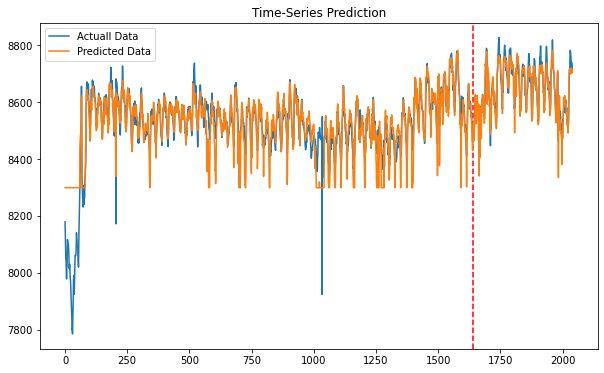

In [68]:
predict(df)